In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

#import theano
#THEANO_FLAGS='device=cuda,floatX=float32'
#theano.config.floatX = 'float32'
%matplotlib inline

Networkx version: 2.3


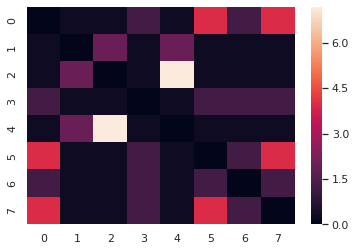

In [194]:
G = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
H = G.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0)
ax = sns.heatmap(A.todense())

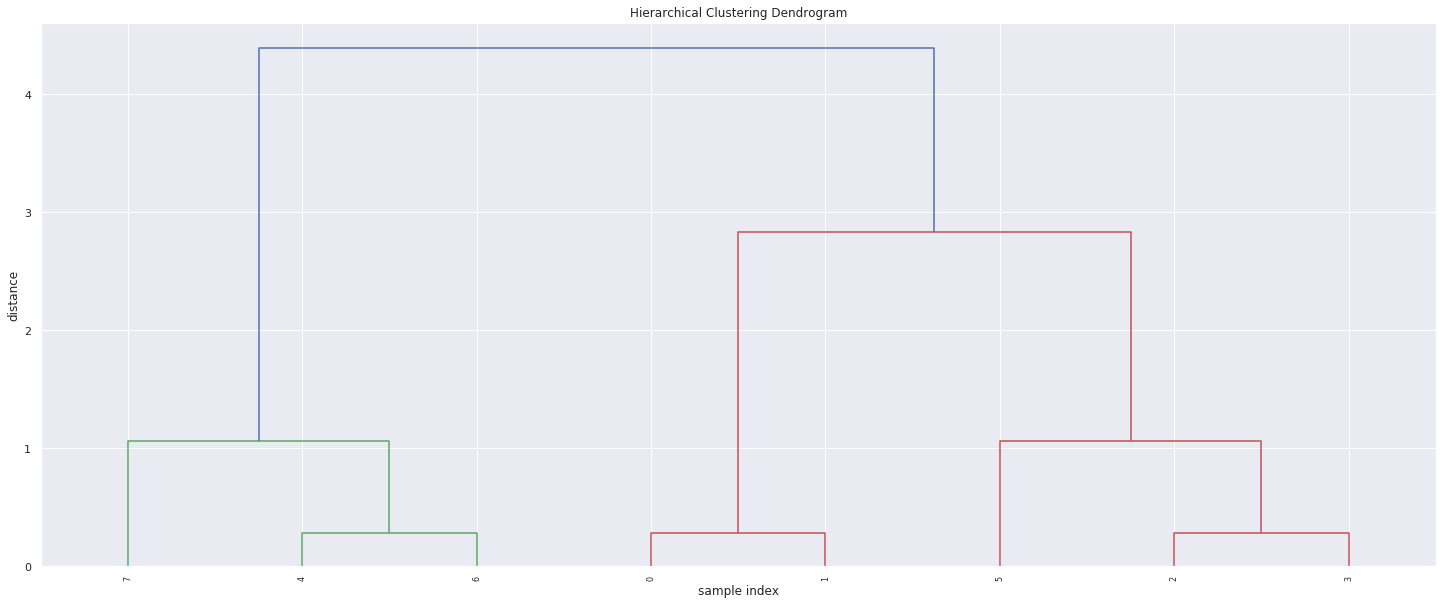

array([[ 0.        ,  1.        ,  0.27963638,  2.        ],
       [ 2.        ,  3.        ,  0.27963638,  2.        ],
       [ 4.        ,  6.        ,  0.27963638,  2.        ],
       [ 5.        ,  9.        ,  1.05721886,  3.        ],
       [ 7.        , 10.        ,  1.05721886,  3.        ],
       [ 8.        , 11.        ,  2.8306456 ,  5.        ],
       [12.        , 13.        ,  4.38778294,  8.        ]])

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

listA = squareform(A.todense())
Z = linkage(listA, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [4]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, labels, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = labels #pm.Categorical('z', p=pi, shape=(n,))
        eta = pm.Normal('eta', mu=10, sd = 1, shape=(k, k))#.astype('float32')
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))]
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices]
        W = pm.Normal('W', mu=p, sd=1, shape=A_obs[0].shape, observed=A_obs)#.astype('float32')
    return model

In [49]:
k = 3
labels = np.full(shape=len(G),fill_value=0)
labels[::3] = 1
model = make_pymc3_sbm(G, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(500, tune = 500)

/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [47:47<00:00,  4.92draws/s]
The acceptanc

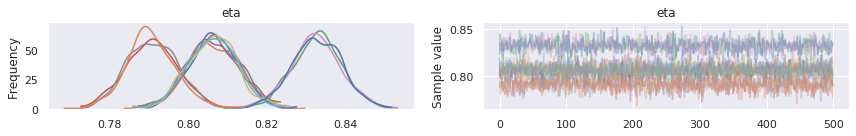

In [17]:
pm.traceplot(trace1);

In [18]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,0.806526,0.006289,0.000156,0.795399,0.819532,1509.904629,0.999666
eta__0_1,0.832539,0.006468,0.000164,0.820724,0.846360,1588.340047,1.000041
eta__1_0,0.806286,0.006623,0.000130,0.792825,0.819012,1971.517655,0.999522
eta__1_1,0.790701,0.006497,0.000165,0.777662,0.803034,1713.584897,0.999712


In [239]:
def updateDAG(G, NodeMerge):
    size = len(NodeMerge);
    u,v = NodeMerge[0]
    for i in range (0,size):
        print(NodeMerge[i])
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        B = np.vstack([A, (A[nodes[0],:]+A[nodes[1],:])/2])
        A = np.column_stack([B, (B[:,nodes[0]]+B[:,nodes[1]])/2])
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    H = nx.from_numpy_matrix(A)
    H.remove_node(u)
    H.remove_node(v)
    #print(H.node())
    return H

In [111]:
def getCandidates(G, labels):
    A = nx.adjacency_matrix(G).todense()
    np.fill_diagonal(A, 9999)
    am = A.argmin() #find min pair
    c0 = am % A.shape[1]
    r0 = am // A.shape[1]
    A[c0,r0] = 9999
    A[r0,c0] = 9999
    c1 = A[r0,:].argmin() #find 2nd min pair
    r1 = A[:,c0].argmin() #find 2nd min pair
    
    Llist = []    
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c0]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[c0] = labelsNew[r1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    return Llist

In [175]:
def buildLayer(G, k, Llist):
    Mlist = []
    Tlist = []

    for iteration in range (0,3):
        labels = Llist[iteration]
        model = make_pymc3_sbm(G, k, labels)
        with model as modelX:
            trace = pm.sample(1500, tune = 500)
        Mlist.append(modelX)
        Tlist.append(trace)

    Mlist[0].name = '0'
    Mlist[1].name = '1'
    Mlist[2].name = '2'
    comp = pm.compare({Mlist[0]: Tlist[0], Mlist[1]: Tlist[1], Mlist[2]: Tlist[2]}, method='BB-pseudo-BMA')
    #print(comp.weight)
    return comp.weight

In [241]:
from collections import Counter

dup = [item for item, count in Counter(Llist[1]).items() if count > 1]
nodes = np.where(Llist[1] == dup[0])
nodes[0]

label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Gnew = G0 
while True:
    k = len(Gnew)
    label = np.arange(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    thresh = ModelPosterior['0'] + 0.3 #use the closest pair as the posterior threshold, increase to speed up convergence
    newInternal = ModelPosterior[ModelPosterior  > thresh].index.astype(int)
    NodeMerge = [] #nodes to be merged, closest pair added as the defult
    dup = [item for item, count in Counter(Llist[0]).items() if count > 1]
    nodes = np.where(Llist[0] == dup[0])
    NodeMerge.append(nodes[0])
    print(Llist[0])
    for i in range (0,len(newInternal)):
        newLabel = Llist[newInternal[i]]
        print(newLabel)
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        nodes = np.where(newLabel == dup[0])
        NodeMerge.append(nodes[0])
    Gnew = updateDAG(Gnew, NodeMerge) #update the graph with node mergers/splits
    if k<=3:
        break    

/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1143.46draws/s]
Auto-assign

0     0.5
2    0.42
1    0.08
Name: weight, dtype: object
[0 0 1 2 3 4 5 6]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1216.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1230.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1288.38draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

0    0.45
2    0.43
1    0.12
Name: weight, dtype: object
[0 0 1 2 3 4 5]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1377.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1298.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1360.14draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

0    0.58
1     0.4
2    0.03
Name: weight, dtype: object
[0 0 1 2 3 4]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:09<00:00, 620.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1226.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 906.65draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

2    0.69
0    0.26
1    0.05
Name: weight, dtype: object
[1 0 1 2 3]
[0 1 2 2 3]
[0 2]
[2 3]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1063.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:09<00:00, 621.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 932.53draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

1    0.48
2    0.45
0    0.07
Name: weight, dtype: object
[0 2 1 2 3]
[0 0 1 2 3]
[0 1 2 3 3]
[1 3]
[0 1]
[3 4]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1362.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1370.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1329.97draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

2    0.97
0    0.03
1       0
Name: weight, dtype: object
[3 0 1 2 3 4]
[0 1 2 3 4 4]
[0 4]
[4 5]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1359.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1332.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1345.03draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

2    0.44
0    0.42
1    0.14
Name: weight, dtype: object
[0 1 1 2 3 4]
[1 2]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:07<00:00, 819.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:12<00:00, 467.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1319.49draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

0    0.48
2    0.46
1    0.07
Name: weight, dtype: object
[0 1 1 2 3]
[1 2]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:07<00:00, 815.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1122.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 941.04draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

1    0.48
2    0.44
0    0.08
Name: weight, dtype: object
[0 2 1 2]
[0 1 1 2]
[0 1 2 2]
[1 3]
[1 2]
[2 3]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1183.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1149.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:09<00:00, 614.89draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pre

0    0.45
2    0.42
1    0.13
Name: weight, dtype: object
[0 1 1 2 3]
[1 2]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 996.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1015.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 895.65draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

2    0.51
0    0.39
1     0.1
Name: weight, dtype: object
[0 1 1 2]
[1 2]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2470.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2418.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2612.77draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

1    0.48
0    0.45
2    0.07
Name: weight, dtype: object
[0 1 1]
[1 2]


/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [153]:
Llist[newInternal[0]]

array([0, 2, 1, 2, 3, 4, 5, 6])

In [112]:
label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Llist = getCandidates(G0,label)
Llist

[array([0, 0, 1, 2, 3, 4, 5, 6]),
 array([1, 0, 1, 2, 3, 4, 5, 6]),
 array([0, 2, 1, 2, 3, 4, 5, 6])]